# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

# Import Data

Data download is found at (download all files): https://www.kaggle.com/competitions/nfl-playing-surface-analytics

In [3]:
%%time
# set working directory - warning this takes time, player dataset is large

df_injury = pd.read_csv('InjuryRecord.csv', ) #small
# remove columns that are unneeded to make loading data faster
df_player = pd.read_csv('PlayerTrackData.csv', usecols = ['PlayKey', 'time', 'x', 'y', 'dis', 's', 'dir']) # large file
df_play = pd.read_csv('PlayList.csv') #small

CPU times: total: 45 s
Wall time: 45.9 s


In [4]:
df_player.dtypes

PlayKey     object
time       float64
x          float64
y          float64
dir        float64
dis        float64
s          float64
dtype: object

In [5]:
df_play.dtypes

PlayerKey          int64
GameID            object
PlayKey           object
RosterPosition    object
PlayerDay          int64
PlayerGame         int64
StadiumType       object
FieldType         object
Temperature        int64
Weather           object
PlayType          object
PlayerGamePlay     int64
Position          object
PositionGroup     object
dtype: object

In [6]:
df_injury.dtypes

PlayerKey     int64
GameID       object
PlayKey      object
BodyPart     object
Surface      object
DM_M1         int64
DM_M7         int64
DM_M28        int64
DM_M42        int64
dtype: object

# Filtering for Performance

None of the datasets except for df_player include timestamps during the play, therefore we have no way of knowing at what time an injury occurred during a play, only what play the injury occurred in. Since the df_player dataset is so large, we will filter the df_player dataset to time = 0 (at the start of each play) for efficiency and for joining so that we do not create duplicate rows when joining onto df_play and df_injury.

In [7]:
print('the length before filtering', len(df_player))

the length before filtering 76366748


In [8]:
%%time

df_player_filtered = df_player[df_player['time'] == 0.0]

CPU times: total: 422 ms
Wall time: 445 ms


In [9]:
print('the length after filtering', len(df_player_filtered)) #reduces the dataset 200+ times

the length after filtering 266960


In [10]:
# verify that all plays were included - this should match the length of df_player_filtered!

len(df_player['PlayKey'].unique())

266960

# First Look at Datasets

CPU times: total: 17.9 s
Wall time: 19.2 s


array([[<Axes: title={'center': 'time'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'y'}>, <Axes: title={'center': 'dir'}>],
       [<Axes: title={'center': 'dis'}>, <Axes: title={'center': 's'}>]],
      dtype=object)

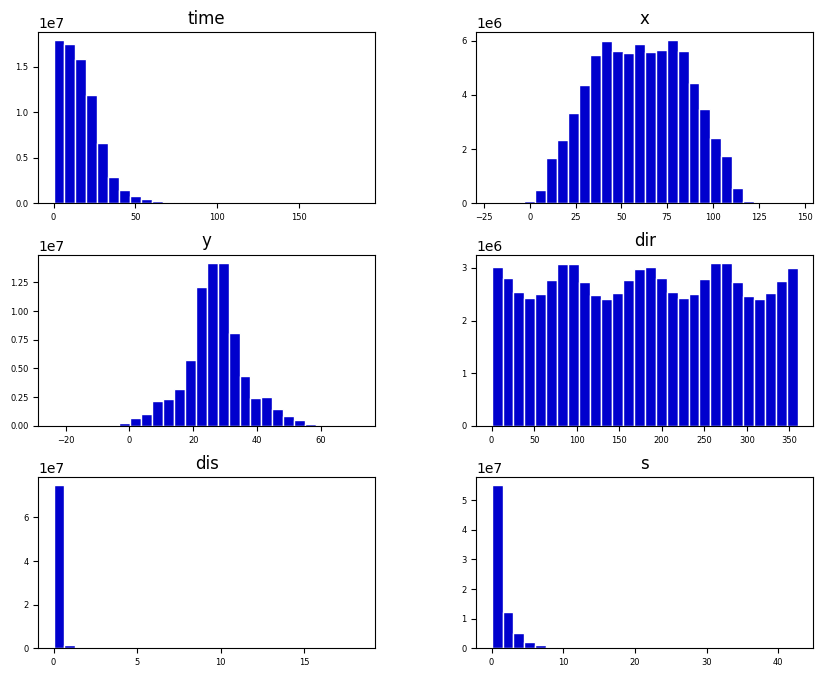

In [11]:
%%time

df_player.hist(grid = False, xlabelsize = 6, ylabelsize = 6, bins = 'sturges', figsize = (10,8), color = 'mediumblue', edgecolor = 'w')

# player's position, speed and direction throughout a play indexed by time. 
# x and y represent player position along the sideline and endzone respectively
# dis indicates distance traveled and dir indicates direction traveled
# s indicates the speed of the player

array([[<Axes: title={'center': 'PlayerKey'}>,
        <Axes: title={'center': 'PlayerDay'}>],
       [<Axes: title={'center': 'PlayerGame'}>,
        <Axes: title={'center': 'Temperature'}>],
       [<Axes: title={'center': 'PlayerGamePlay'}>, <Axes: >]],
      dtype=object)

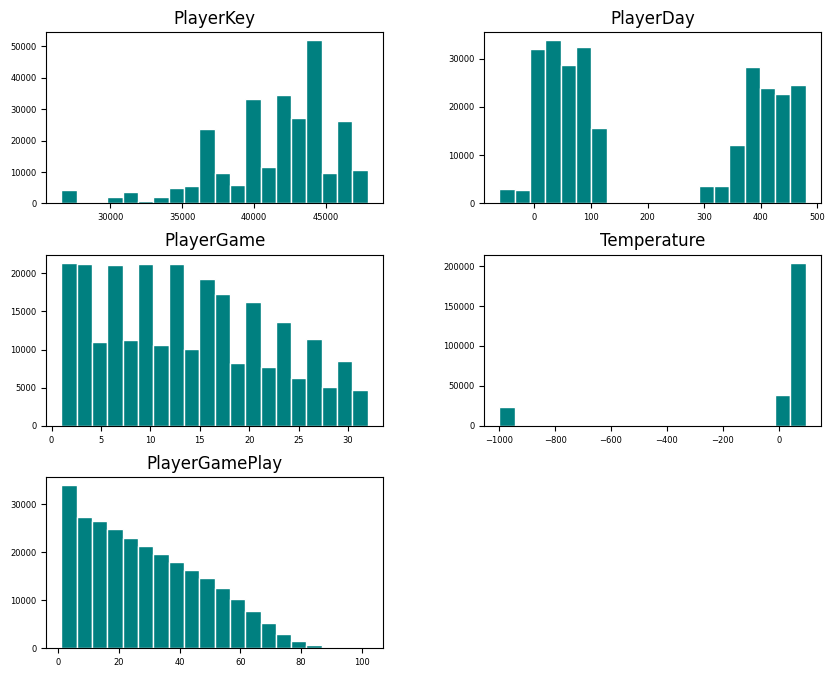

In [12]:
df_play.hist(grid = False, xlabelsize = 6, ylabelsize = 6, bins = 'sturges', figsize = (10,8), color = 'teal', edgecolor = 'w')

# info on each play
# various joining keys (PlayerKey, GameID, PlayKey)
# Temperature during the game, ordering of games during the day and of plays during the game

array([[<Axes: title={'center': 'PlayerKey'}>,
        <Axes: title={'center': 'DM_M1'}>],
       [<Axes: title={'center': 'DM_M7'}>,
        <Axes: title={'center': 'DM_M28'}>],
       [<Axes: title={'center': 'DM_M42'}>, <Axes: >]], dtype=object)

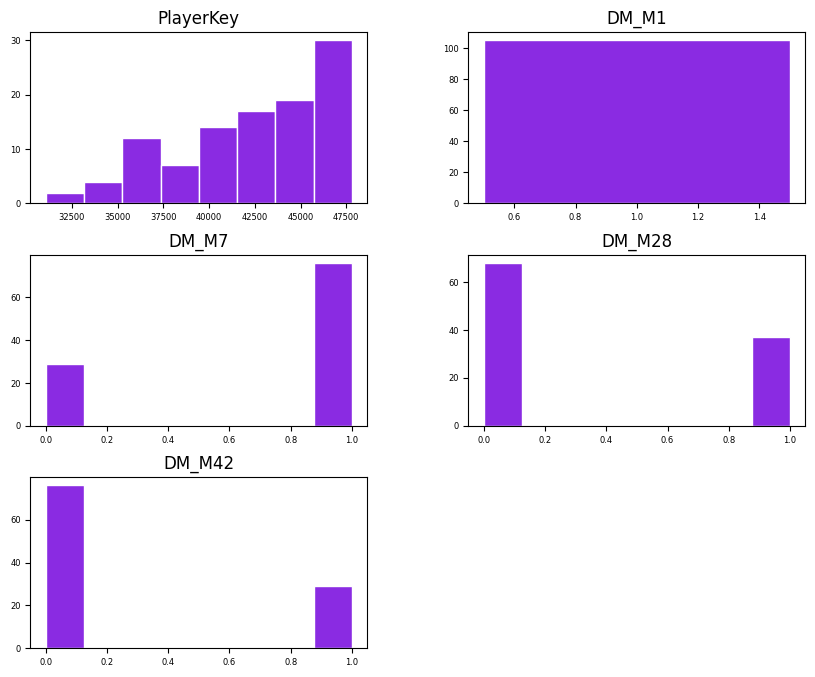

In [13]:
df_injury.hist(grid = False, xlabelsize = 6, ylabelsize = 6, bins = 'sturges', figsize = (10,8), color = 'blueviolet', edgecolor = 'w')

# information on injuries
# various joining keys
# dm_mxx represents how many injuries resulted in days missed of 1 or more, 7 or more, 28 or more or 42 or more. 

# Removing NAs

In [14]:
# check for nas
df_injury.isna().sum() # 28 in PlayKey - drop these rows as we can't join them

PlayerKey     0
GameID        0
PlayKey      28
BodyPart      0
Surface       0
DM_M1         0
DM_M7         0
DM_M28        0
DM_M42        0
dtype: int64

In [15]:
print('the length before dropping na is:', len(df_injury))

df_injury = df_injury.dropna()

print('the length after dropping na is:', len(df_injury))

the length before dropping na is: 105
the length after dropping na is: 77


In [16]:
# check for nas
df_play.isna().sum() # drop nas in stadium type, weather and play type to avoid issues in later visualizations.

PlayerKey             0
GameID                0
PlayKey               0
RosterPosition        0
PlayerDay             0
PlayerGame            0
StadiumType       16910
FieldType             0
Temperature           0
Weather           18691
PlayType            367
PlayerGamePlay        0
Position              0
PositionGroup         0
dtype: int64

In [17]:
print('the length before dropping na is:', len(df_play))

df_play = df_play.dropna()

print('the length after dropping na is:', len(df_play))

the length before dropping na is: 267005
the length after dropping na is: 231996


In [19]:
# check for nas
df_player_filtered.isna().sum() # No NAs

PlayKey    0
time       0
x          0
y          0
dir        0
dis        0
s          0
dtype: int64

# Grouping and evaluting outliers

In [21]:
for col in df_injury.columns:
    if 'Key' in col:
        pass
    elif 'ID' in col:
        pass
    else:
        print('unique values of', col, df_injury[col].unique())
        
# looks like DM M1 may be missing 0 values - let's investigate

unique values of BodyPart ['Knee' 'Ankle' 'Foot']
unique values of Surface ['Synthetic' 'Natural']
unique values of DM_M1 [1]
unique values of DM_M7 [1 0]
unique values of DM_M28 [1 0]
unique values of DM_M42 [1 0]


In [22]:
df_injury['DM_M1'].value_counts()

# this looks fine, all injuries took had at least 1 day missed which makes sense.

1    77
Name: DM_M1, dtype: int64

In [23]:
for col in df_play.columns:
    if 'Key' in col:
        pass
    elif 'ID' in col:
        pass
    else:
        print('unique values of', col, df_play[col].unique())
        
# make grouped types for stadium type and weather type 
# maybe a grouped weather type
# change -999 in temperature and 0 in play type to unknown

unique values of RosterPosition ['Quarterback' 'Wide Receiver' 'Linebacker' 'Running Back'
 'Defensive Lineman' 'Tight End' 'Safety' 'Cornerback' 'Offensive Lineman'
 'Kicker']
unique values of PlayerDay [  1  11  18  25  29  39  46  53  67  74  81  88  96 102 109 116 368 375
 382 389 393 403 410 418 424 431 445 452 459 466 473 480   7  14  35  42
  49  56  63  70  77  84 105 112 364 371 406 413 420 427 434 438 455 463
 469   8  16  22  43  57  71  99 106 113 365 372 379 386 400 404 414 428
 435 449 456 470 477  26  32  54  95 101 369  15 362 450 -55 -41 -34 -27
 -23  -5  23  36 295 302 309 316 337 341 351 358 407  44  50  64  75 394
 421  37  68  78  85  92 425 442  33 107  21  91 378 448 462 476  19  58
 366 471 -62 -48 -44 -20 -13  -6  30 310 330 344 305 319 334 355 396 340
 347 354 361 390 417  60  82 422 443 453 415  79 296 313 323 380   5 411
 387  86  12  40  98 373 392 399 441 461 439  72  89 100 408  47 376 436
 464  76 440 401 429 385 383 457 274 288 104   9 359 306 432  97 4

In [24]:
# replace 0 in play type as unknown

df_play[df_play['PlayType'] == '0'].count() #249 rows

PlayerKey         249
GameID            249
PlayKey           249
RosterPosition    249
PlayerDay         249
PlayerGame        249
StadiumType       249
FieldType         249
Temperature       249
Weather           249
PlayType          249
PlayerGamePlay    249
Position          249
PositionGroup     249
dtype: int64

In [25]:
df_play.loc[df_play['PlayType'] == '0', 'PlayType'] = 'unknown'

df_play[df_play['PlayType'] == 'unknown'].count() # if 249 it worked

PlayerKey         249
GameID            249
PlayKey           249
RosterPosition    249
PlayerDay         249
PlayerGame        249
StadiumType       249
FieldType         249
Temperature       249
Weather           249
PlayType          249
PlayerGamePlay    249
Position          249
PositionGroup     249
dtype: int64

In [26]:
# grouped categories for stadium type

df_play['StadiumType'].unique()

array(['Outdoor', 'Indoors', 'Oudoor', 'Outdoors', 'Open', 'Closed Dome',
       'Dome', 'Indoor', 'Domed', 'Retr. Roof-Closed', 'Retractable Roof',
       'Ourdoor', 'Indoor, Roof Closed', 'Retr. Roof - Closed', 'Bowl',
       'Outddors', 'Retr. Roof-Open', 'Indoor, Open Roof', 'Domed, Open',
       'Domed, open', 'Heinz Field', 'Cloudy', 'Retr. Roof - Open',
       'Retr. Roof Closed', 'Outdor', 'Outside'], dtype=object)

In [27]:
# create grouped category for indoor/outdoor stadium types

StadiumType_list = []

for x in df_play['StadiumType']:
    if x in ('Outdoor', 'Oudoor', 'Outdoors', 'Ourdoor', 'Outddors', 'Heinz Field', 'Cloudy', 'Outdor', 'Outside', 'Bowl',
             'Open', 'Retr. Roof-Open', 'Indoor, Open Roof', 'Domed, Open', 'Domed, open', 'Retr. Roof - Open'):
        StadiumType_list.append('Outdoor')
        
    elif x in ('Indoors', 'Indoor', 'Closed Dome', 'Indoor, Roof Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed', 'Retr. Roof-Closed'):
        StadiumType_list.append('Indoor')
        
    elif x in ('Dome', 'Domed', 'Retractable Roof'):
        StadiumType_list.append('Indoor/Outdoor Unknown')
        
    else:
        StadiumType_list.append('fix me')
        
df_play['StadiumTypeGrouped'] = StadiumType_list

In [28]:
df_play['StadiumTypeGrouped'].value_counts() # checking counts

Outdoor                   186297
Indoor                     28636
Indoor/Outdoor Unknown     17063
Name: StadiumTypeGrouped, dtype: int64

In [29]:
# grouped categories for weather type

weather_types = df_play['Weather'].unique()

for x in weather_types:
    print(x.lower())

clear and warm
mostly cloudy
sunny
clear
cloudy
cloudy, fog started developing in 2nd quarter
rain
partly cloudy
mostly cloudy
cloudy and cold
cloudy and cool
rain chance 40%
controlled climate
sunny and warm
partly cloudy
clear and cool
clear and cold
sunny and cold
indoor
partly sunny
n/a (indoors)
mostly sunny
indoors
clear skies
partly sunny
showers
n/a indoor
sunny and clear
snow
scattered showers
party cloudy
clear skies
rain likely, temps in low 40s.
hazy
partly clouidy
sunny skies
overcast
cloudy, 50% change of rain
partly clear
mostly coudy
light rain
10% chance of rain
cloudy, chance of rain
heat index 95
sunny, highs to upper 80s
sun & clouds
heavy lake effect snow
fair
mostly sunny
cloudy, rain
sunny, windy
mostly sunny skies
rainy
30% chance of rain
cloudy, light snow accumulating 1-3"
cloudy
clear and sunny
coudy
clear and sunny
clear to partly cloudy
cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.
rain shower
cold


In [30]:
Weathertype_list = []
# clear/sunny, partly sunny/partly cloudy, cloudy, rain, controlled climate/indoors, snow, unknown 

for x in df_play['Weather']:
    if x.lower() in ('clear and warm', 'sunny', 'clear', 'sunny and warm', 'clear and cool', 'clear and cold', 'sunny and cold', 
                     'mostly sunny', 'clear skies', 'sunny and clear', 'party cloudy', 'sunny skies', 'sunny, highs to upper 80s', 
                     'sunny, windy', 'mostly sunny skies', 'clear and sunny'):
        Weathertype_list.append('clear/sunny')
    
    elif x.lower() in ('partly cloudy', 'partly sunny', 'partly clouidy', 'partly clear', 'sun & clouds', 'clear to partly cloudy', 
                       ''):
        Weathertype_list.append('partly cloudy')
    
    elif x.lower() in ('mostly cloudy', 'cloudy', 'cloudy, fog started developing in 2nd quarter', 'cloudy and cold', 
                       'cloudy and cool', 'overcast', 'cloudy, 50% change of rain', 'mostly coudy', 'cloudy, chance of rain',
                       'coudy'):
        Weathertype_list.append('cloudy')
    
    elif x.lower() in ('controlled climate', 'indoor', 'n/a (indoors)', 'indoors', 'n/a indoor'):
        Weathertype_list.append('indoors/controlled climate')
    
    elif x.lower() in ('rain', 'showers', 'scattered showers', 'light rain', 'rainy', 'cloudy, rain', 
                       'cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.', 
                       'rain shower'):
        Weathertype_list.append('rain')
    
    elif x.lower() in ('snow', 'heavy lake effect snow', 'cloudy, light snow accumulating 1-3"'):
        Weathertype_list.append('snow')
    
    elif x.lower() in ('rain chance 40%', 'rain likely, temps in low 40s.', 'hazy', '10% chance of rain', 'heat index 95', 'fair', 
                       '30% chance of rain', 'cold'):
        Weathertype_list.append('unknown')
    
    else:
        Weathertype_list.append('fix me')
        
df_play['WeatherGrouped'] = Weathertype_list

In [31]:
df_play['WeatherGrouped'].value_counts() # checking

clear/sunny                   88009
cloudy                        74480
partly cloudy                 30731
indoors/controlled climate    20246
rain                          11261
unknown                        5324
snow                           1945
Name: WeatherGrouped, dtype: int64

(array([ 7545., 35140., 64481., 72990., 38691.]),
 array([ 9. , 26.6, 44.2, 61.8, 79.4, 97. ]),
 <BarContainer object of 5 artists>)

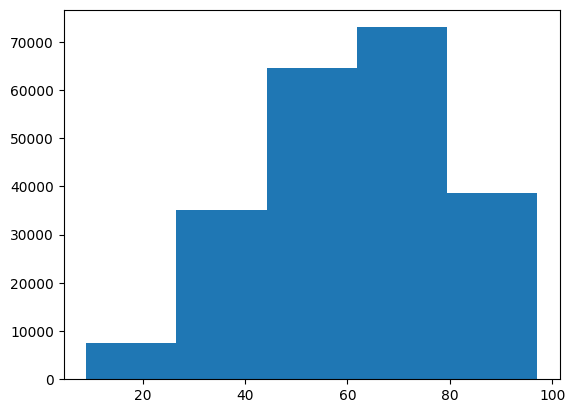

In [32]:
# grouped temperature

t = df_play[df_play['Temperature'] != -999]

plt.hist(t['Temperature'], bins = 5) # checking to see distribution for groupings

In [33]:
temp_list = []

for x in df_play['Temperature']:
    
    if x == -999:
        temp_list.append('0. unknown')
        
    elif x < 15:
        temp_list.append('1. less than 15 degrees')
    
    elif x < 30:
        temp_list.append('2. 15 to 30 degrees')
        
    elif x < 45:
        temp_list.append('3. 30 to 45 degrees')
        
    elif x < 60:
        temp_list.append('4. 45 to 60 degrees')
        
    elif x < 75:
        temp_list.append('5. 60 to 75 degrees')
        
    elif x < 90:
        temp_list.append('6. 75 to 90 degrees')
        
    else:
        temp_list.append('7. greater than 90 degrees')
        
df_play['TemperatureGrouped'] = temp_list

In [34]:
df_play['TemperatureGrouped'].value_counts()

5. 60 to 75 degrees           70647
4. 45 to 60 degrees           52124
6. 75 to 90 degrees           49194
3. 30 to 45 degrees           31935
0. unknown                    13149
2. 15 to 30 degrees            8975
7. greater than 90 degrees     4197
1. less than 15 degrees        1775
Name: TemperatureGrouped, dtype: int64

In [35]:
for col in df_player_filtered.columns:
    if 'Key' in col:
        pass
    elif 'ID' in col:
        pass
    else:
        print('unique values of', col, df_player[col].unique())
        
# all of these values look like they make sense!

unique values of time [0.000e+00 1.000e-01 2.000e-01 ... 1.867e+02 1.868e+02 1.869e+02]
unique values of x [ 87.46  87.45  87.44 ... 129.58 129.57 128.51]
unique values of y [28.93 28.92 28.91 ... 66.18 66.14 64.22]
unique values of dir [288.24 283.91 280.4  ... 189.9    6.9     nan]
unique values of dis [1.000e-02 0.000e+00 2.000e-02 6.000e-02 2.100e-01 2.800e-01 2.300e-01
 1.600e-01 1.100e-01 1.000e-01 9.000e-02 8.000e-02 7.000e-02 5.000e-02
 4.000e-02 3.000e-02 1.500e-01 3.700e-01 4.800e-01 4.600e-01 3.900e-01
 3.600e-01 3.400e-01 3.500e-01 3.100e-01 2.600e-01 2.400e-01 1.700e-01
 1.300e-01 1.200e-01 1.400e-01 5.100e-01 3.800e-01 3.200e-01 2.900e-01
 2.700e-01 1.800e-01 4.200e-01 2.200e-01 2.000e-01 1.900e-01 4.500e-01
 3.000e-01 2.500e-01 3.300e-01 4.000e-01 4.100e-01 4.700e-01 4.300e-01
 4.400e-01 4.900e-01 5.600e-01 5.500e-01 5.300e-01 5.000e-01 5.400e-01
 6.000e-01 5.200e-01 5.700e-01 6.100e-01 5.800e-01 5.900e-01 7.800e-01
 7.400e-01 7.200e-01 6.300e-01 6.600e-01 6.500e-01 6.40

# Visualizations

## Surface Type and Body Part Injured

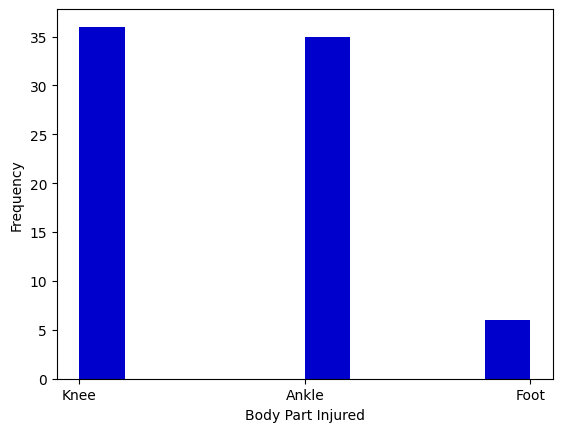

In [36]:
plt.hist(df_injury['BodyPart'], color = 'mediumblue')
plt.xlabel('Body Part Injured')
plt.ylabel('Frequency')
plt.show()

# this tells us the distribution of injury but what about the surface? Plus this is pretty plain. Let's try to display both!

In [37]:
df_injury.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [38]:
# make a new dataframe with sorted counts of each injury type + turf type

df_injury['BodyPartAndSurface'] = df_injury['BodyPart'] + " " + df_injury['Surface']

df_sort = df_injury['BodyPartAndSurface'].value_counts().to_frame(name = 'count').reset_index()

df_sort = df_sort.sort_values(by = ['count'], ascending = False)

df_sort['Body Part'] = df_sort['index']

df_sort.drop('index', axis = 'columns', inplace = True)

df_sort

,count,Body Part
0,21,Ankle Synthetic
1,18,Knee Synthetic
2,18,Knee Natural
3,14,Ankle Natural
4,4,Foot Natural
5,2,Foot Synthetic


<BarContainer object of 6 artists>

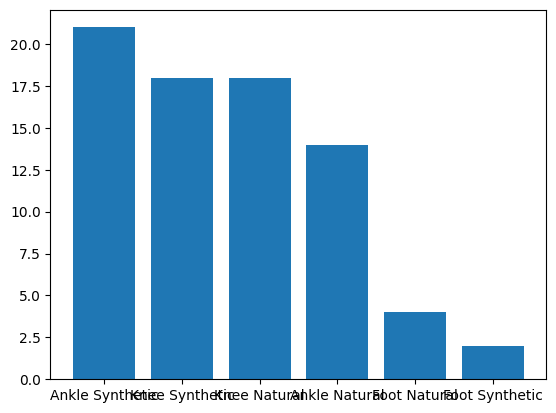

In [39]:
plt.bar(df_sort['Body Part'], df_sort['count'])

# The order looks good, now let's format!

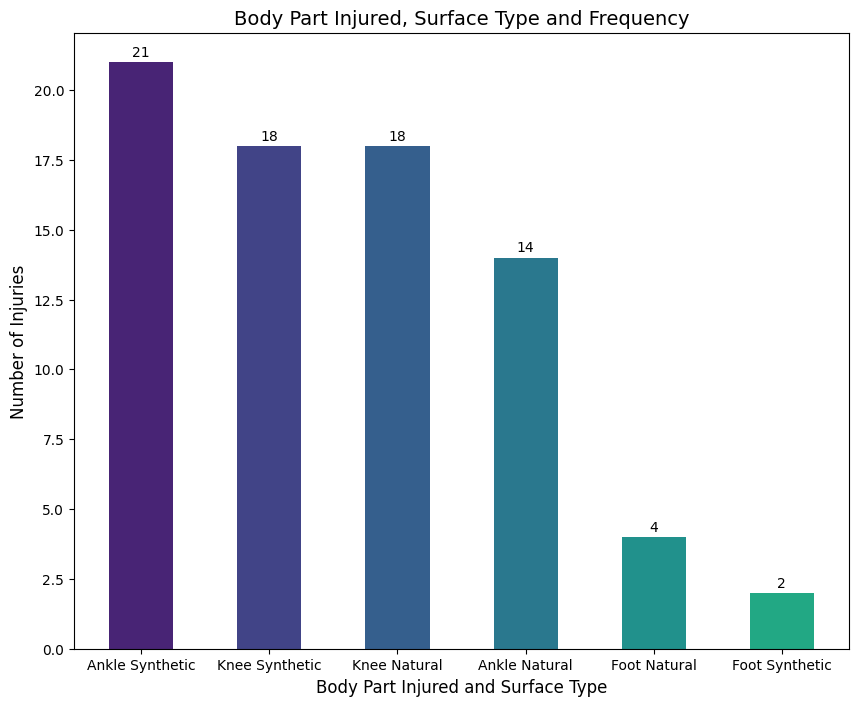

In [40]:
fig, ax = plt.subplots(figsize = (10,8))

# get colors for sequential coloring of bars
cmap = plt.get_cmap('viridis') # use viridis for accessibility
ints = [0 + (0.1 * (i+1)) for i in range(len(df_sort['Body Part']))] 
cmap_colors = [cmap(i) for i in ints]

# plot bar
hbars = ax.bar(df_sort['Body Part'], df_sort['count'], width = 0.5, color = cmap_colors)

# set axes/labels parameters
ax.tick_params(labelsize = 10, labelrotation = 0)
ax.set_xlabel('Body Part Injured and Surface Type', size = 12)
ax.set_ylabel('Number of Injuries', size = 12)
ax.bar_label(hbars, fontsize = 10, padding = 2)
ax.set_title('Body Part Injured, Surface Type and Frequency', size = 14)


plt.show()

## Injury and Time Missed

In [41]:
# let's create a column that we can use to assess the length of time players are out by injury type

time_list = []

for i in range(len(df_injury)): 
    s = df_injury.iloc[i]['DM_M42'] + df_injury.iloc[i]['DM_M28'] +  df_injury.iloc[i]['DM_M7'] +  df_injury.iloc[i]['DM_M1']
#     print(sum)
    if s == 4:
        time_list.append('days42+')
    elif s == 3:
        time_list.append('days28to42')
    elif s == 2:
        time_list.append('days7to28')
    else:
        time_list.append('days1to7')
    
df_injury['time_missed'] = time_list

In [42]:
df_injury['time_missed'].value_counts()

days7to28     29
days42+       24
days1to7      17
days28to42     7
Name: time_missed, dtype: int64

In [43]:
injury_time = df_injury.groupby('BodyPart')['time_missed'].value_counts(normalize = True).round(2).unstack().reset_index()

injury_time = injury_time.fillna(0)

injury_time

time_missed,BodyPart,days1to7,days28to42,days42+,days7to28
0,Ankle,0.34,0.06,0.26,0.34
1,Foot,0.00,0.33,0.67,0.00
2,Knee,0.14,0.08,0.31,0.47


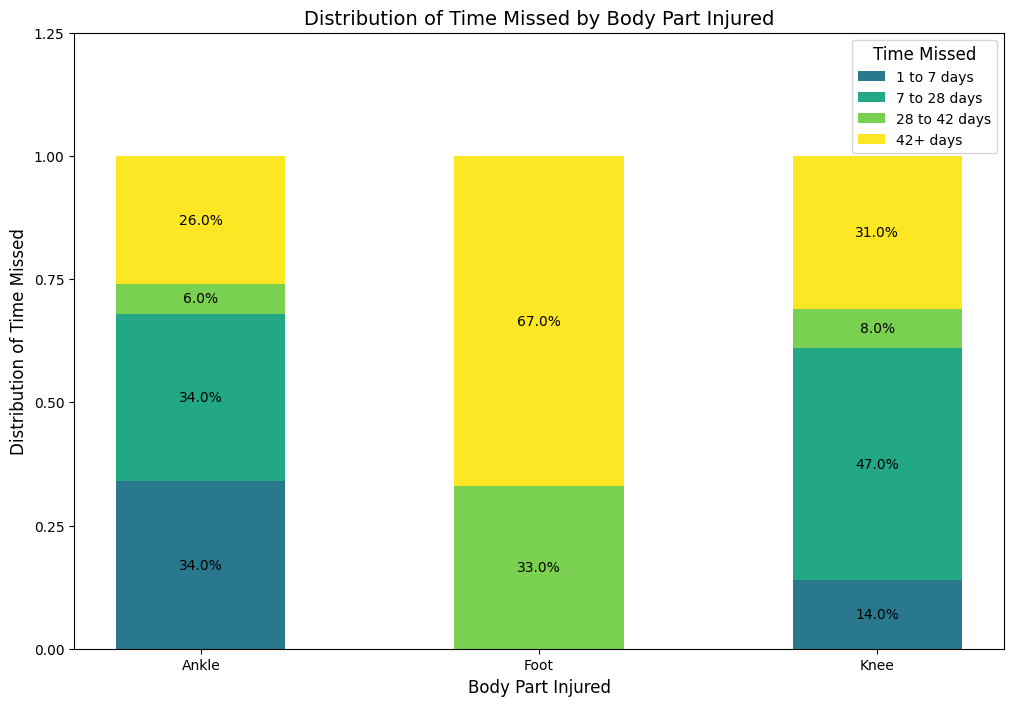

In [44]:
fig, ax = plt.subplots(figsize = (12,8))

# create bars/set colors
cmap = plt.get_cmap('viridis') # use viridis for accessibility

ax.bar(injury_time['BodyPart'], injury_time['days1to7'], label = '1 to 7 days', width = 0.5, color = cmap(0.4))
ax.bar(injury_time['BodyPart'], injury_time['days7to28'], bottom = injury_time.days1to7,
       label = '7 to 28 days', width = 0.5, color = cmap(0.6))
ax.bar(injury_time['BodyPart'], injury_time['days28to42'], bottom = injury_time.days7to28 + injury_time.days1to7,
       label = '28 to 42 days', width = 0.5, color = cmap(0.8))
ax.bar(injury_time['BodyPart'], injury_time['days42+'], bottom = injury_time.days28to42 + injury_time.days7to28 + injury_time.days1to7,
       label = '42+ days', width = 0.5, color = cmap(1.0))

# set axes/labels parameters
ax.tick_params(labelsize = 10, labelrotation = 0)
ax.set_xlabel('Body Part Injured', size = 12)
ax.set_ylabel('Distribution of Time Missed', size = 12)
ax.set_yticks(np.arange(0, 1.5, 0.25)) # for legend formatting
ax.set_title('Distribution of Time Missed by Body Part Injured', size = 14)

# Add labels to bars 
for c in ax.containers:
    labels = [str(round(v.get_height()*100, 0)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 10)
    
# create legend
ax.legend(labels = ["1 to 7 days", "7 to 28 days", '28 to 42 days', '42+ days'],
          fontsize = 10,
          title = "Time Missed",
          title_fontsize = 12,
         loc = 'upper right')


# Joining the datasets

In [45]:
%%time

# joining datasets with granularity of 1 row per play

df_play_injury = df_play.merge(df_injury, on = ['PlayerKey', 'GameID', 'PlayKey'], how = 'left')

df_play_all = df_play_injury.merge(df_player_filtered, on = ['PlayKey'], how = 'left')

CPU times: total: 422 ms
Wall time: 457 ms


In [46]:
df_play_all.head(10)

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,StadiumTypeGrouped,WeatherGrouped,TemperatureGrouped,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,BodyPartAndSurface,time_missed,time,x,y,dir,dis,s
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,87.46,28.93,288.24,0.01,0.13
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,88.74,28.02,69.05,0.02,0.08
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,79.11,28.44,355.90,0.04,0.07
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,71.61,27.71,246.82,0.02,0.16
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,68.71,26.37,230.16,0.01,0.12
5,26624,26624-1,26624-1-6,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,6,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,46.37,23.78,267.17,0.06,0.41
6,26624,26624-1,26624-1-7,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,7,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45.11,23.48,100.19,0.00,0.07
7,26624,26624-1,26624-1-8,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,8,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,25.59,23.64,277.15,0.06,0.53
8,26624,26624-1,26624-1-9,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,9,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.47,21.99,335.70,0.02,0.43
9,26624,26624-1,26624-1-10,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,10,QB,QB,Outdoor,clear/sunny,5. 60 to 75 degrees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.99,22.07,353.24,0.06,0.60


In [47]:
%%time

# create target variable

tar_list = []

for i in range(len(df_play_all)):
    
    if pd.isnull(df_play_all.iloc[i]['BodyPart']) == True:
        tar_list.append(0)
    
    else: 
        tar_list.append(1)
        
df_play_all['target'] = tar_list

CPU times: total: 20.1 s
Wall time: 20.3 s


## Injury Rate

Injury rate will be calculated as the number of plays (rows) with injury (not null body part) divided by the total number of plays (rows). It will represent the proportion of plays for a given variable that had injury. 

In [48]:
# first we will define a function for calculating injury rate
def injury_rate(var):
    '''
    Calculates injury rate using target variable based on an input variable from the df_play_all dataframe.
    Returns dataframe for use in visualizations
    
    '''
    temp = df_play_all.groupby([var])['target'].sum().to_frame().reset_index() # occurrence of injuries 

    temp['total'] = df_play_all.groupby([var])['PositionGroup'].count().to_list()

    temp['injury_rate'] = round((temp['target'] / temp['total'])*100,4)
    
    return(temp)

In [49]:
# example of how the function works
injury_rate('FieldType')

,FieldType,target,total,injury_rate
0,Natural,35,143970,0.0243
1,Synthetic,35,88027,0.0398


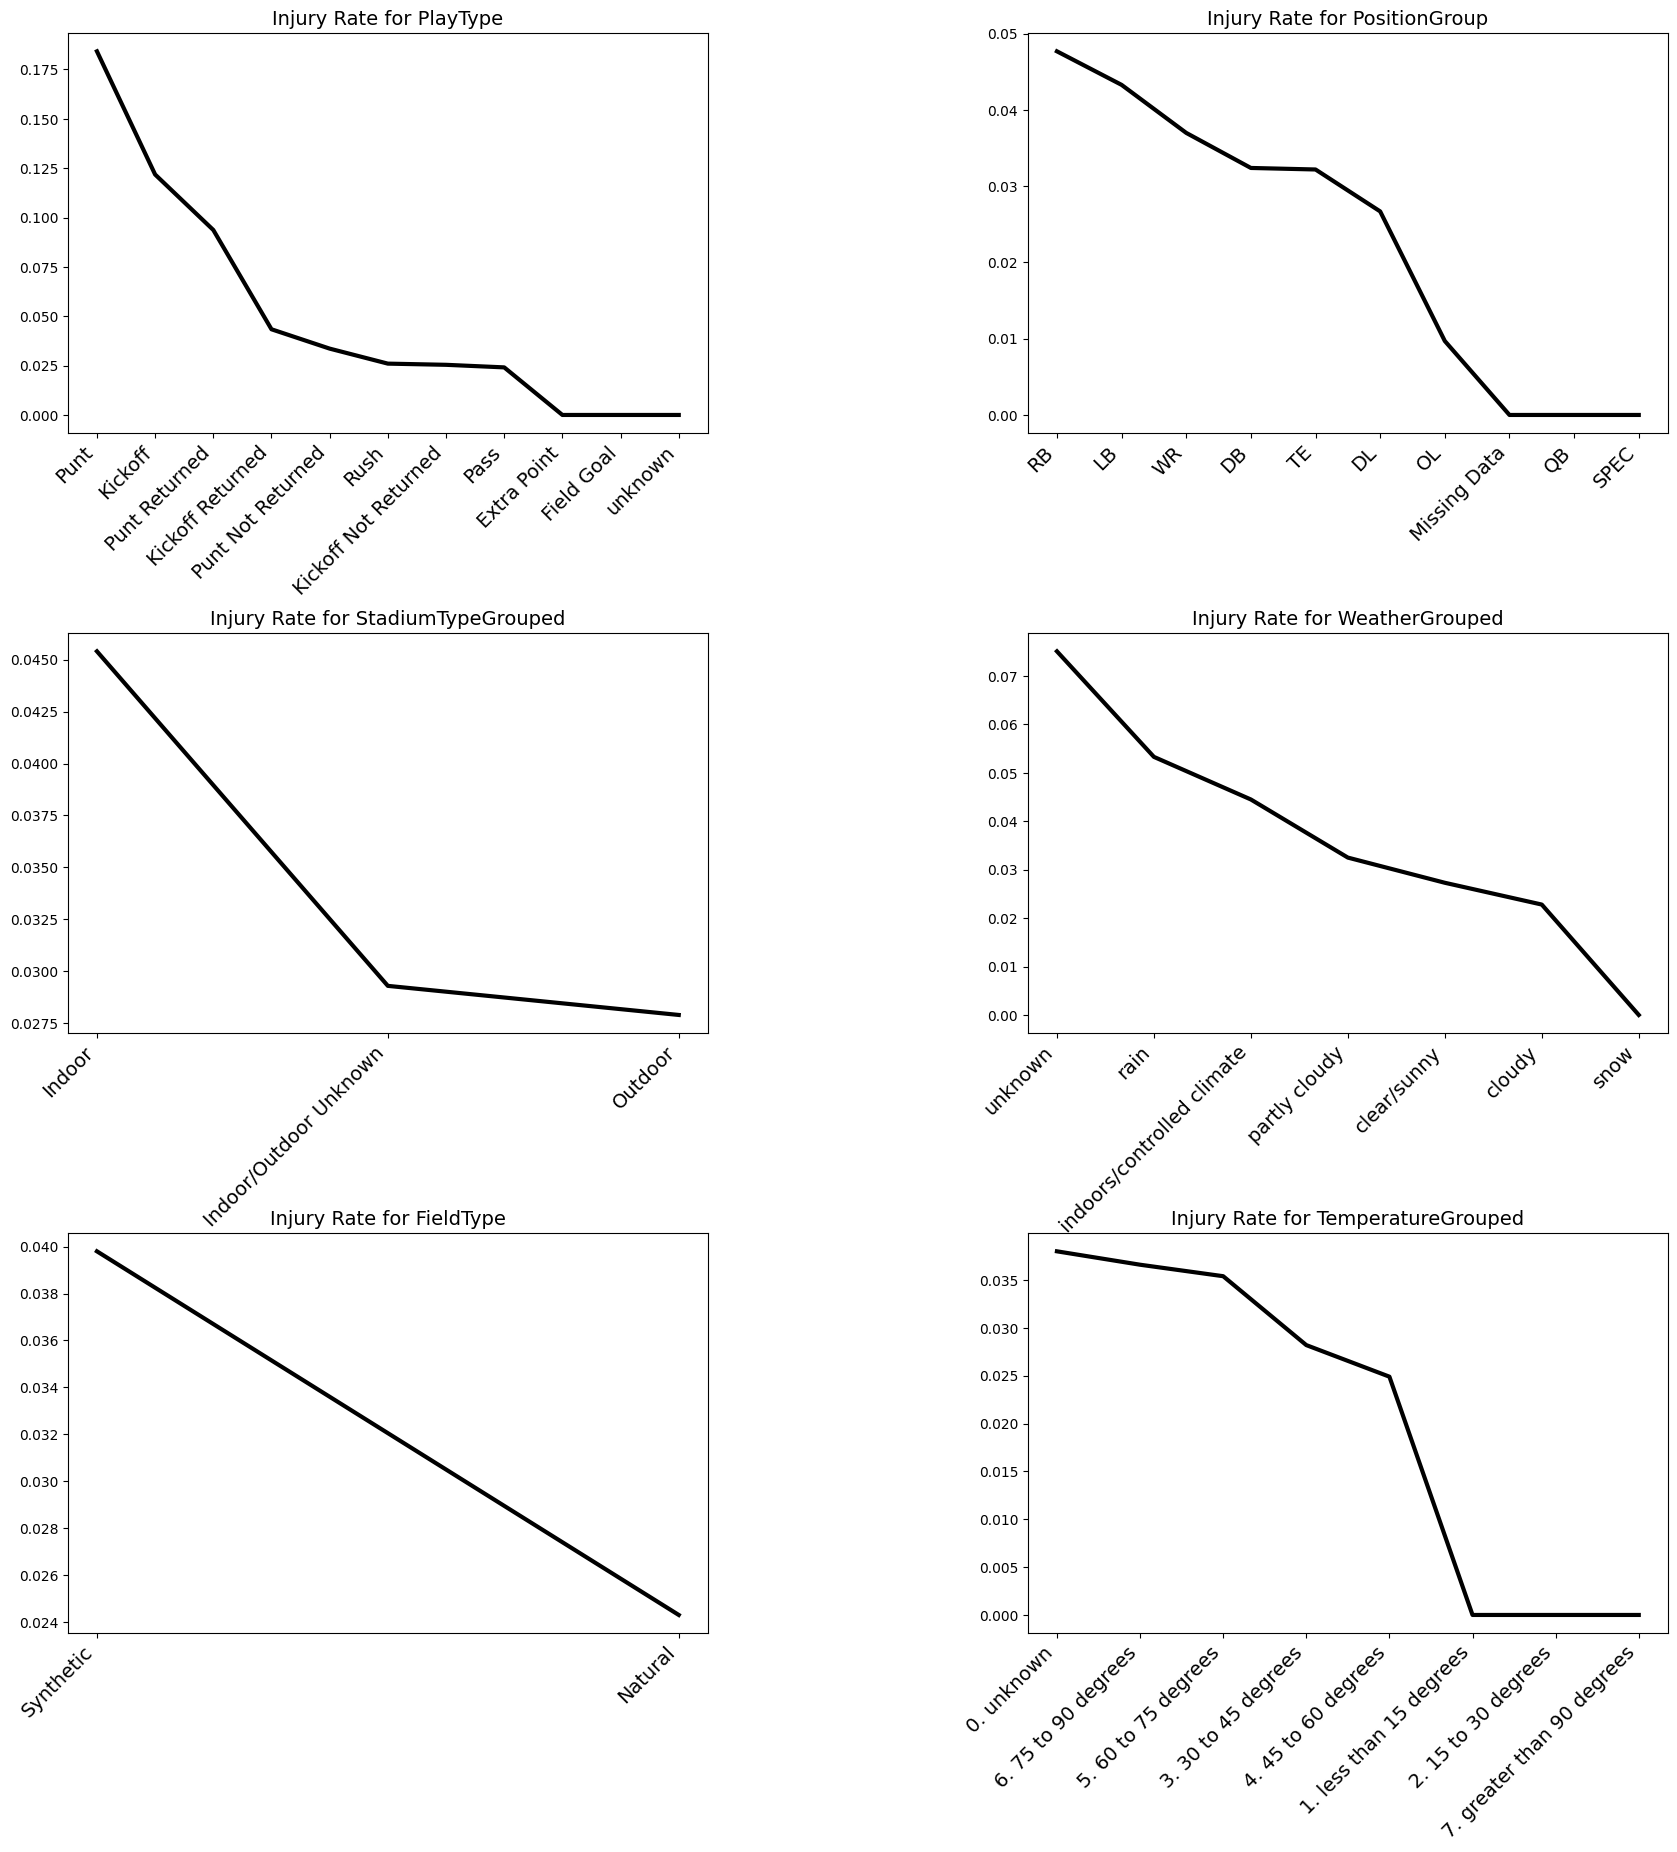

In [50]:
cats = ['PlayType', 'PositionGroup', 'StadiumTypeGrouped', 'WeatherGrouped', 'FieldType', 'TemperatureGrouped']

plt.figure(figsize = (20,20))

for i in range(len(cats)): 
    ax = plt.subplot(3, 2, i + 1)

    df = injury_rate(cats[i]).sort_values(by = 'injury_rate', ascending = False)
    title = 'Injury Rate for ' + cats[i]
    plt.plot(df[cats[i]], df['injury_rate'], color = 'black', linewidth = 3)
    ax.set_title(title, size = 14)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.5)
    plt.xticks(rotation = 45, size = 14, ha = 'right') 

## Distribution of Player Statistics

<Axes: >

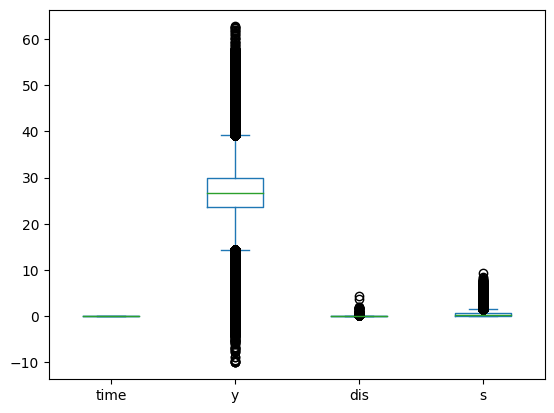

In [51]:
df_player_filtered[['time', 'y', 'dis', 's']].plot(kind = 'box')

<Axes: >

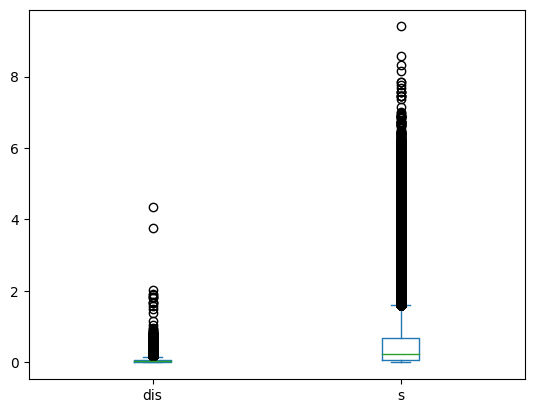

In [52]:
df_player_filtered[['dis', 's']].plot(kind = 'box')

# the boxplots above all look a little rough! Let's plot boxplots with similar ranges on the same figure and do some formatting.

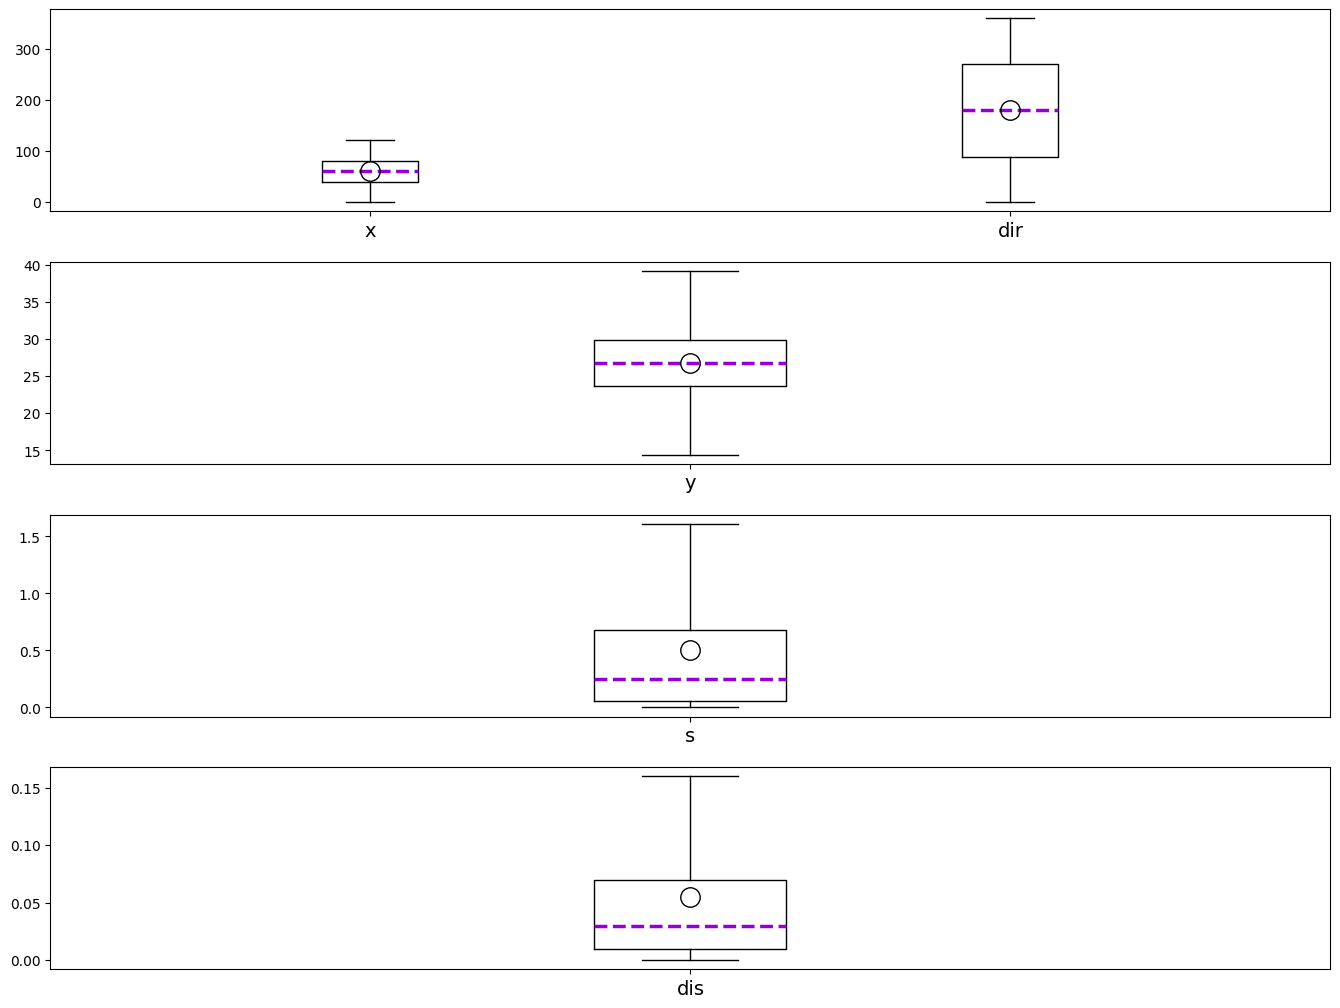

In [53]:
plt.figure(figsize = (16,12))

box_list = [['x', 'dir'], ['y'], ['s'], ['dis']]

for i in range(len(box_list)): 
    ax = plt.subplot(4, 1, i + 1)

    # format median and mean style
    medianprops = dict(linestyle='--', linewidth=2.5, color='darkviolet')
    meanpointprops = dict(marker='o', markeredgecolor='black', markerfacecolor='none', markersize = 14)
    plt.boxplot(df_player_filtered[box_list[i]], labels = box_list[i], sym = "", showmeans = True, medianprops = medianprops, 
               meanprops = meanpointprops)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.25)
    plt.xticks(rotation = 0, size = 14, ha = 'center') 


## Correlation of Continuous Variables to Injury

In [54]:
cont_variables = ['PlayerDay', 'PlayerGame', 'Temperature', 'x', 'y', 'dir', 'dis', 's', 'target']

df_all_cont = df_play_all.filter(cont_variables)

df_all_cont

,PlayerDay,PlayerGame,Temperature,x,y,dir,dis,s,target
0,1,1,63,87.46,28.93,288.24,0.01,0.13,0
1,1,1,63,88.74,28.02,69.05,0.02,0.08,0
2,1,1,63,79.11,28.44,355.90,0.04,0.07,0
3,1,1,63,71.61,27.71,246.82,0.02,0.16,0
4,1,1,63,68.71,26.37,230.16,0.01,0.12,0
...,...,...,...,...,...,...,...,...,...
231992,99,13,33,39.63,25.53,67.49,0.05,0.45,0
231993,99,13,33,51.77,24.61,186.24,0.11,1.08,0
231994,99,13,33,56.80,13.49,191.09,0.28,2.73,0
231995,99,13,33,55.33,27.44,237.85,0.07,0.68,0


In [55]:
# create correlation matrix

corr = df_all_cont.corr()

corr

,PlayerDay,PlayerGame,Temperature,x,y,dir,dis,s,target
PlayerDay,1.000000,0.889215,-0.006008,-0.011962,0.000455,0.002963,-0.015556,-0.001620,-0.006472
PlayerGame,0.889215,1.000000,-0.003023,-0.007581,-0.001510,0.002890,-0.011445,0.000297,-0.010374
Temperature,-0.006008,-0.003023,1.000000,0.011159,-0.002170,0.001914,0.003750,0.000828,-0.000850
x,-0.011962,-0.007581,0.011159,1.000000,0.008297,-0.006465,-0.001274,-0.002956,-0.004440
y,0.000455,-0.001510,-0.002170,0.008297,1.000000,-0.002949,0.001933,-0.000111,-0.001480
dir,0.002963,0.002890,0.001914,-0.006465,-0.002949,1.000000,-0.002172,-0.002968,-0.006523
dis,-0.015556,-0.011445,0.003750,-0.001274,0.001933,-0.002172,1.000000,0.950983,0.001622
s,-0.001620,0.000297,0.000828,-0.002956,-0.000111,-0.002968,0.950983,1.000000,0.001900
target,-0.006472,-0.010374,-0.000850,-0.004440,-0.001480,-0.006523,0.001622,0.001900,1.000000


[Text(0.5, 0, 'PlayerDay'),
 Text(1.5, 0, 'PlayerGame'),
 Text(2.5, 0, 'Temperature'),
 Text(3.5, 0, 'x'),
 Text(4.5, 0, 'y'),
 Text(5.5, 0, 'dir'),
 Text(6.5, 0, 'dis'),
 Text(7.5, 0, 's'),
 Text(8.5, 0, 'target')]

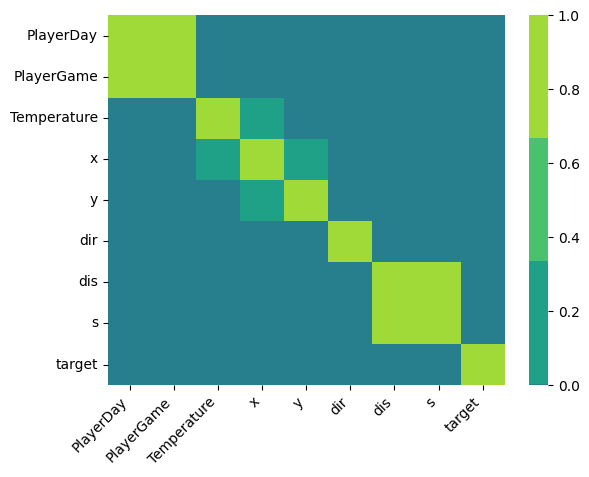

In [56]:
# plot correlation matrix

ax = sns.heatmap(
    corr,
    cmap = sns.color_palette("viridis"),
    vmin = 0, vmax = 1, center = 0.001
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# unfortunately we don't have many significant correlations! let's try to add some more variables by one hot encoding. 

In [57]:
df_play_all.columns

Index(['PlayerKey', 'GameID', 'PlayKey', 'RosterPosition', 'PlayerDay',
       'PlayerGame', 'StadiumType', 'FieldType', 'Temperature', 'Weather',
       'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup',
       'StadiumTypeGrouped', 'WeatherGrouped', 'TemperatureGrouped',
       'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42',
       'BodyPartAndSurface', 'time_missed', 'time', 'x', 'y', 'dir', 'dis',
       's', 'target'],
      dtype='object')

In [58]:
cont_variables = ['PlayerDay', 'PlayerGame', 'Temperature', 'x', 'y', 'dir', 'dis', 's', 'target']

cat_variables = ['PositionGroup', 'StadiumTypeGrouped', 'PlayType', 'FieldType', 'WeatherGrouped', 'TemperatureGrouped']

df_get_dummies = pd.get_dummies(df_play_all, columns = cat_variables)

df_get_dummies.columns

Index(['PlayerKey', 'GameID', 'PlayKey', 'RosterPosition', 'PlayerDay',
       'PlayerGame', 'StadiumType', 'Temperature', 'Weather', 'PlayerGamePlay',
       'Position', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42',
       'BodyPartAndSurface', 'time_missed', 'time', 'x', 'y', 'dir', 'dis',
       's', 'target', 'PositionGroup_DB', 'PositionGroup_DL',
       'PositionGroup_LB', 'PositionGroup_Missing Data', 'PositionGroup_OL',
       'PositionGroup_QB', 'PositionGroup_RB', 'PositionGroup_SPEC',
       'PositionGroup_TE', 'PositionGroup_WR', 'StadiumTypeGrouped_Indoor',
       'StadiumTypeGrouped_Indoor/Outdoor Unknown',
       'StadiumTypeGrouped_Outdoor', 'PlayType_Extra Point',
       'PlayType_Field Goal', 'PlayType_Kickoff',
       'PlayType_Kickoff Not Returned', 'PlayType_Kickoff Returned',
       'PlayType_Pass', 'PlayType_Punt', 'PlayType_Punt Not Returned',
       'PlayType_Punt Returned', 'PlayType_Rush', 'PlayType_unknown',
       'FieldType_Natural', 'FieldT

In [59]:
drop_cols = ['PlayerKey', 'GameID', 'PlayKey', 'StadiumType', 'Weather', 'PlayerGamePlay', 'RosterPosition', 'Position', 'BodyPart', 
             'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'BodyPartAndSurface', 'Surface', 'time_missed', 'time']

df_OHE = df_get_dummies.drop(drop_cols, axis = 1)

In [60]:
df_OHE.head()

,PlayerDay,PlayerGame,Temperature,x,y,dir,dis,s,target,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_Missing Data,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR,StadiumTypeGrouped_Indoor,StadiumTypeGrouped_Indoor/Outdoor Unknown,StadiumTypeGrouped_Outdoor,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush,PlayType_unknown,FieldType_Natural,FieldType_Synthetic,WeatherGrouped_clear/sunny,WeatherGrouped_cloudy,WeatherGrouped_indoors/controlled climate,WeatherGrouped_partly cloudy,WeatherGrouped_rain,WeatherGrouped_snow,WeatherGrouped_unknown,TemperatureGrouped_0. unknown,TemperatureGrouped_1. less than 15 degrees,TemperatureGrouped_2. 15 to 30 degrees,TemperatureGrouped_3. 30 to 45 degrees,TemperatureGrouped_4. 45 to 60 degrees,TemperatureGrouped_5. 60 to 75 degrees,TemperatureGrouped_6. 75 to 90 degrees,TemperatureGrouped_7. greater than 90 degrees
0,1,1,63,87.46,28.93,288.24,0.01,0.13,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,63,88.74,28.02,69.05,0.02,0.08,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1,63,79.11,28.44,355.90,0.04,0.07,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,1,63,71.61,27.71,246.82,0.02,0.16,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,63,68.71,26.37,230.16,0.01,0.12,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [61]:
corr = df_OHE.corr()

corr

,PlayerDay,PlayerGame,Temperature,x,y,dir,dis,s,target,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_Missing Data,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR,StadiumTypeGrouped_Indoor,StadiumTypeGrouped_Indoor/Outdoor Unknown,StadiumTypeGrouped_Outdoor,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush,PlayType_unknown,FieldType_Natural,FieldType_Synthetic,WeatherGrouped_clear/sunny,WeatherGrouped_cloudy,WeatherGrouped_indoors/controlled climate,WeatherGrouped_partly cloudy,WeatherGrouped_rain,WeatherGrouped_snow,WeatherGrouped_unknown,TemperatureGrouped_0. unknown,TemperatureGrouped_1. less than 15 degrees,TemperatureGrouped_2. 15 to 30 degrees,TemperatureGrouped_3. 30 to 45 degrees,TemperatureGrouped_4. 45 to 60 degrees,TemperatureGrouped_5. 60 to 75 degrees,TemperatureGrouped_6. 75 to 90 degrees,TemperatureGrouped_7. greater than 90 degrees
PlayerDay,1.000000,0.889215,-0.006008,-0.011962,0.000455,0.002963,-0.015556,-0.001620,-0.006472,0.001833,0.006723,-0.018511,-0.004728,0.042318,0.016755,-0.033136,0.000603,-0.032580,-0.006689,-0.049462,0.074334,-0.007881,0.006458,-0.006706,-0.133922,0.091314,0.068878,0.010490,-0.130701,0.080648,0.062590,0.000231,-0.029987,0.015738,-0.015738,-0.042371,0.016033,0.024228,0.024407,-0.017463,-0.020960,0.024216,-0.001465,-0.048077,-0.001316,0.082598,0.142620,-0.129181,-0.065999,0.024200
PlayerGame,0.889215,1.000000,-0.003023,-0.007581,-0.001510,0.002890,-0.011445,0.000297,-0.010374,0.007971,0.027660,-0.036642,-0.007555,0.046477,0.006390,-0.055828,-0.006386,-0.038342,0.004116,-0.058257,0.065316,0.005311,0.003387,-0.008662,-0.122098,0.053268,0.044709,0.015072,-0.116372,0.056058,0.039746,0.014475,-0.025858,0.013221,-0.013221,-0.060478,0.070834,0.001016,0.002232,-0.037600,0.016093,0.012319,-0.015452,0.007843,0.072729,0.143574,0.204134,-0.163402,-0.164062,-0.026573
Temperature,-0.006008,-0.003023,1.000000,0.011159,-0.002170,0.001914,0.003750,0.000828,-0.000850,0.032105,-0.011764,-0.034795,0.004259,0.017628,-0.008979,-0.018904,0.009627,-0.014497,0.010382,-0.385099,-0.191401,0.444119,0.004387,0.001213,-0.010874,-0.000429,0.005411,0.000727,-0.011566,0.002358,0.000732,0.002453,0.002108,0.192961,-0.192961,0.146248,0.132014,-0.657297,0.102834,0.053118,0.008802,0.038980,-0.997561,0.003845,0.019540,0.062236,0.111376,0.177328,0.172013,0.050360
x,-0.011962,-0.007581,0.011159,1.000000,0.008297,-0.006465,-0.001274,-0.002956,-0.004440,-0.002889,0.000037,-0.001054,NaN,0.003490,-0.002323,0.000970,0.000575,0.000872,0.000906,-0.006047,0.018726,-0.007290,-0.002292,0.004077,-0.003233,-0.001531,-0.000767,0.000303,-0.003001,-0.002372,-0.005818,0.003683,-0.003955,-0.001813,0.001813,-0.007304,0.004914,-0.012735,0.008263,0.011180,0.006411,-0.006303,-0.011000,-0.003643,0.003550,0.001863,-0.002627,-0.005281,0.011742,0.001966
y,0.000455,-0.001510,-0.002170,0.008297,1.000000,-0.002949,0.001933,-0.000111,-0.001480,0.002375,-0.001277,-0.002803,NaN,-0.000135,-0.004996,0.001472,-0.000687,0.000380,0.002766,-0.005003,-0.001021,0.004808,0.000368,-0.000026,-0.003539,0.001926,0.006367,0.000493,0.004076,-0.001739,-0.005799,-0.000854,-0.002928,0.004116,-0.004116,0.000284,0.002468,0.000301,-0.006262,0.008007,-0.001343,-0.005683,0.002401,0.000529,0.000767,-0.004076,-0.001002,-0.000885,0.002506,0.003425
dir,0.002963,0.002890,0.001914,-0.006465,-0.002949,1.000000,-0.002172,-0.002968,-0.006523,-0.005270,0.001847,0.001294,NaN,0.005448,0.002222,0.002672,-0.001690,0.002597,-0.005784,-0.004981,-0.001151,0.004875,-0.000303,-0.000647,-0.000667,0.000427,-0.003268,-0.002222,-0.004295,0.002086,-0.001217,0.004431,-0.000158,0.003569,-0.003569,0.006065,-0.003036,-0.003763,0.003451,-0.003379,-0.002934,-0.004267,-0.002486,-0.000151,0.000094,0.006765,0.004119,-0.001488,-0.003974,-0.008783
dis,-0.015556,-0.011445,0.003750,-0.001

[Text(0.5, 0, 'PlayerDay'),
 Text(1.5, 0, 'PlayerGame'),
 Text(2.5, 0, 'Temperature'),
 Text(3.5, 0, 'x'),
 Text(4.5, 0, 'y'),
 Text(5.5, 0, 'dir'),
 Text(6.5, 0, 'dis'),
 Text(7.5, 0, 's'),
 Text(8.5, 0, 'target'),
 Text(9.5, 0, 'PositionGroup_DB'),
 Text(10.5, 0, 'PositionGroup_DL'),
 Text(11.5, 0, 'PositionGroup_LB'),
 Text(12.5, 0, 'PositionGroup_Missing Data'),
 Text(13.5, 0, 'PositionGroup_OL'),
 Text(14.5, 0, 'PositionGroup_QB'),
 Text(15.5, 0, 'PositionGroup_RB'),
 Text(16.5, 0, 'PositionGroup_SPEC'),
 Text(17.5, 0, 'PositionGroup_TE'),
 Text(18.5, 0, 'PositionGroup_WR'),
 Text(19.5, 0, 'StadiumTypeGrouped_Indoor'),
 Text(20.5, 0, 'StadiumTypeGrouped_Indoor/Outdoor Unknown'),
 Text(21.5, 0, 'StadiumTypeGrouped_Outdoor'),
 Text(22.5, 0, 'PlayType_Extra Point'),
 Text(23.5, 0, 'PlayType_Field Goal'),
 Text(24.5, 0, 'PlayType_Kickoff'),
 Text(25.5, 0, 'PlayType_Kickoff Not Returned'),
 Text(26.5, 0, 'PlayType_Kickoff Returned'),
 Text(27.5, 0, 'PlayType_Pass'),
 Text(28.5, 0, 'Pla

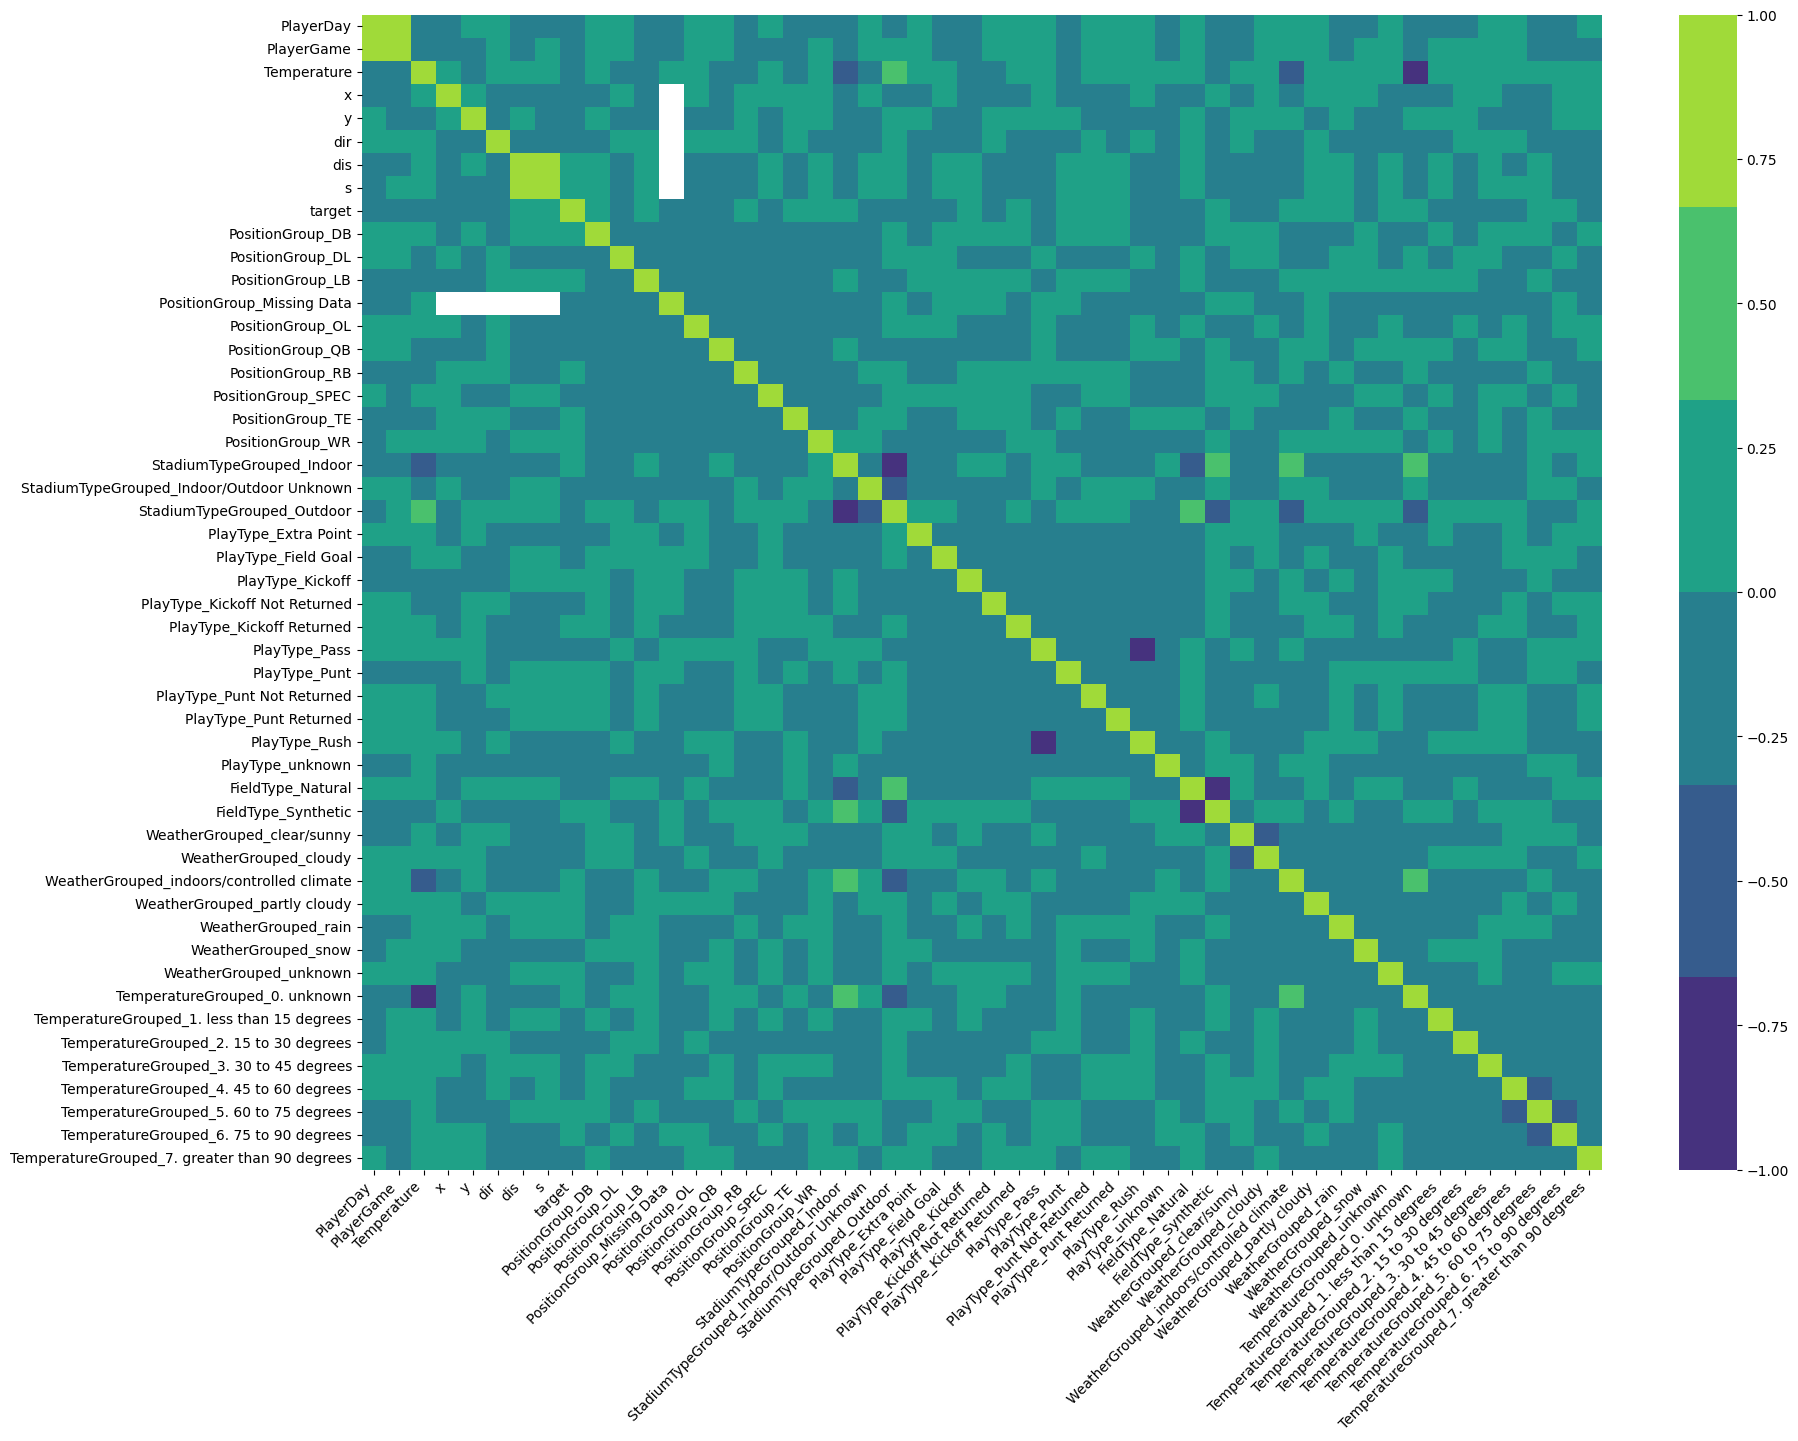

In [62]:
# plot correlation matrix


plt.subplots(figsize=(20,15))

ax = sns.heatmap(
    corr,
    cmap = sns.color_palette("viridis"))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# Now we see more correlations! Let's look at just target as well.

In [63]:
target_corr = df_OHE.corrwith(df_OHE["target"])

target_corr = target_corr.drop(labels = ['target']) # since correlation to itself is 1, we will drop target.

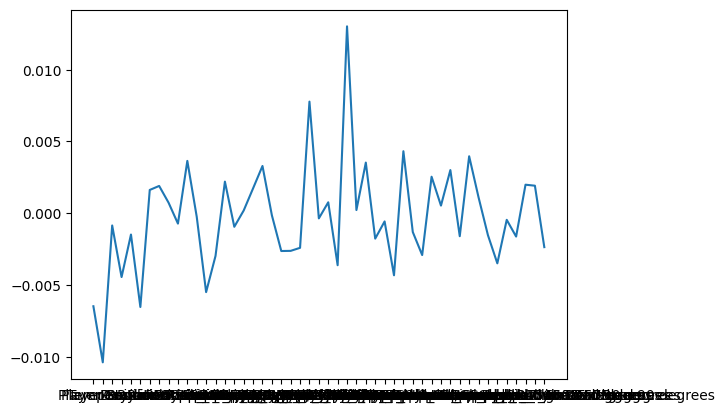

In [64]:
plt.plot(target_corr)

# That's ugly! let's make it better.

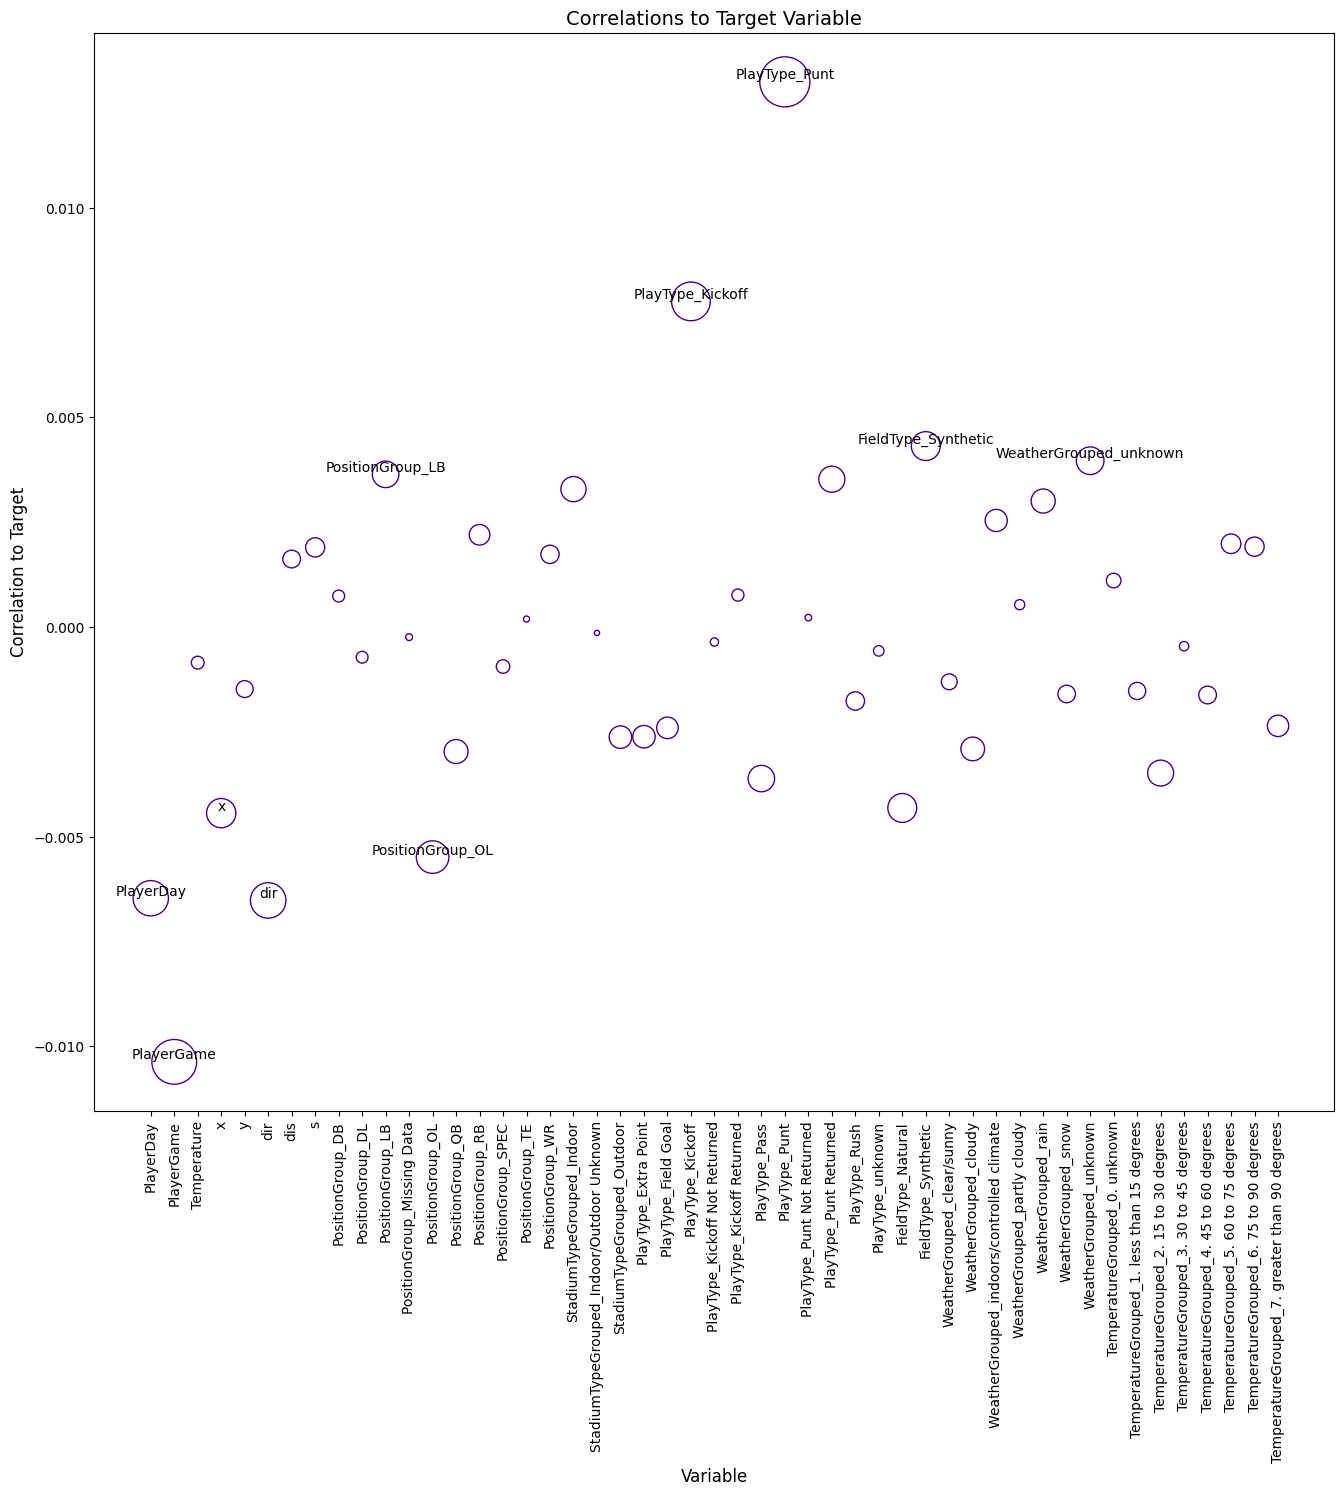

In [65]:
fig, ax = plt.subplots(figsize = (16,14))


# plot scatter with target correlation values
values = target_corr.to_list()
marker_list = [abs(v * 100000) for v in values] # larger correlation means larger circle - using abs to show large correlations whether positive or negative
plt.scatter(target_corr.index, values, s = marker_list, facecolors = 'none', edgecolors = 'indigo')

# format axis
ax.set_xlabel('Variable', size = 12)
ax.set_ylabel('Correlation to Target', size = 12)
ax.set_title('Correlations to Target Variable', size = 14)
plt.xticks(rotation = 90) 

# label top 5 positive correlations
top5_series = pd.concat([target_corr.nlargest(5), target_corr.nsmallest(5)])
top5_values = top5_series.to_list()

for (xi, yi) in zip(top5_series.index, top5_values):
    plt.text(xi, yi, xi, va='bottom', ha='center', size = 10)

## Field Location of Injuries

In [66]:
# filter dataframe to injuries only

df_injury_all = df_play_all[df_play_all['BodyPart'].notnull()]

df_injury_all.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,StadiumTypeGrouped,WeatherGrouped,TemperatureGrouped,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,BodyPartAndSurface,time_missed,time,x,y,dir,dis,s,target
6354,31070,31070-3,31070-3-7,Running Back,15,3,Outdoor,Natural,89,Sunny,Rush,7,RB,RB,Outdoor,clear/sunny,6. 75 to 90 degrees,Knee,Natural,1.0,1.0,1.0,1.0,Knee Natural,days42+,0.0,44.07,32.14,23.31,0.00,0.03,1
9621,33337,33337-8,33337-8-15,Tight End,365,8,Outdoors,Natural,81,Partly Cloudy,Pass,15,TE,TE,Outdoor,partly cloudy,6. 75 to 90 degrees,Foot,Natural,1.0,1.0,1.0,0.0,Foot Natural,days28to42,0.0,95.06,24.67,264.99,0.04,0.41,1
10675,33474,33474-19,33474-19-7,Safety,393,19,Outdoor,Natural,79,Partly Cloudy,Rush,7,FS,DB,Outdoor,partly cloudy,6. 75 to 90 degrees,Knee,Natural,1.0,1.0,1.0,0.0,Knee Natural,days28to42,0.0,56.44,26.88,66.52,0.11,1.08,1
15001,34347,34347-5,34347-5-9,Wide Receiver,39,5,Oudoor,Natural,48,Partly Cloudy,Kickoff,9,WR,WR,Outdoor,partly cloudy,4. 45 to 60 degrees,Knee,Natural,1.0,1.0,0.0,0.0,Knee Natural,days7to28,0.0,39.35,15.78,55.24,0.00,0.09,1
16035,35570,35570-15,35570-15-35,Offensive Lineman,389,15,Outdoor,Natural,79,Clear,Pass,35,T,OL,Outdoor,clear/sunny,6. 75 to 90 degrees,Knee,Natural,1.0,1.0,0.0,0.0,Knee Natural,days7to28,0.0,65.12,25.58,8.10,0.00,0.00,1


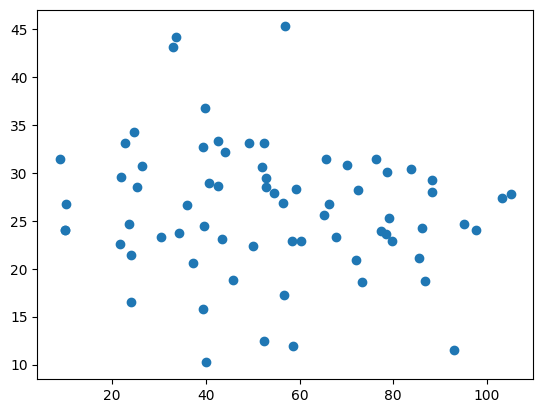

In [67]:
x = df_injury_all['x']

y = df_injury_all['y']

plt.scatter(x,y)

# we've plotted the field locations of all the injuries - now let's make it prettier!

In [68]:
df_injury_all.groupby('BodyPart')

Text(0.5, 1.0, 'Field Location of Injuries')

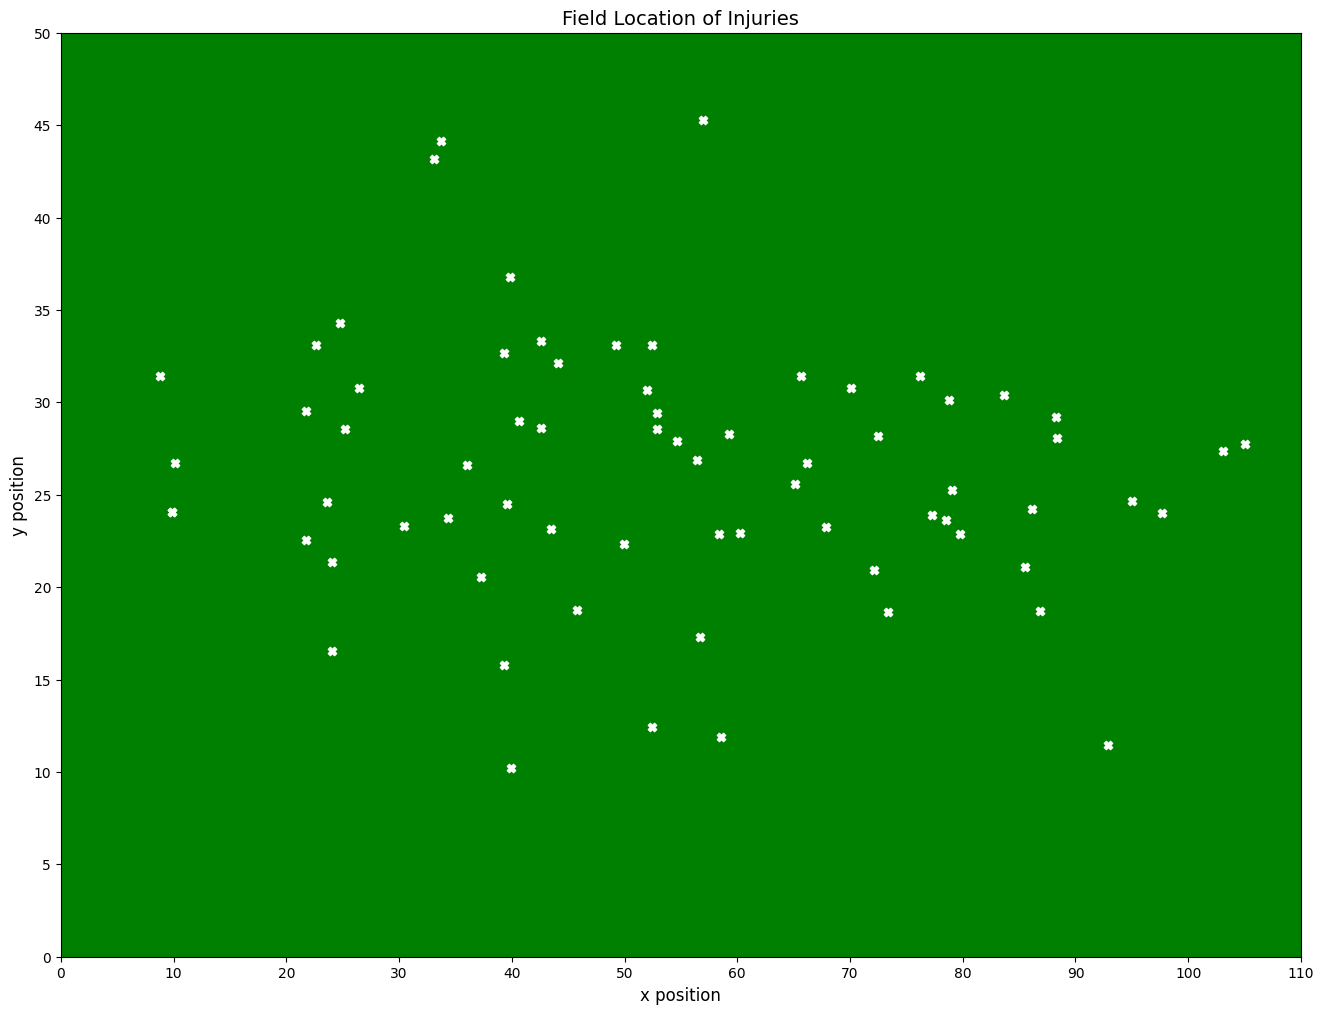

In [69]:
x = df_injury_all['x']

y = df_injury_all['y']

plt.figure(figsize = (16,12))

ax = plt.axes()
ax.set_facecolor('green')

plt.scatter(x, y, marker = 'X', facecolor = 'white')

# set axes - make x and y axis size of football field (120 yards long, 55ish yards wide)
ax.set_yticks(np.arange(0, 55, 5)) 
ax.set_xticks(np.arange(0, 120, 10)) 
ax.set_xlabel('x position', size = 12)
ax.set_ylabel('y position', size = 12)
ax.set_title('Field Location of Injuries', size = 14)

# this looks more like a football field - but it's not really telling us anything interesting. 
# Let's play with the size and color of the markers to show some insights!

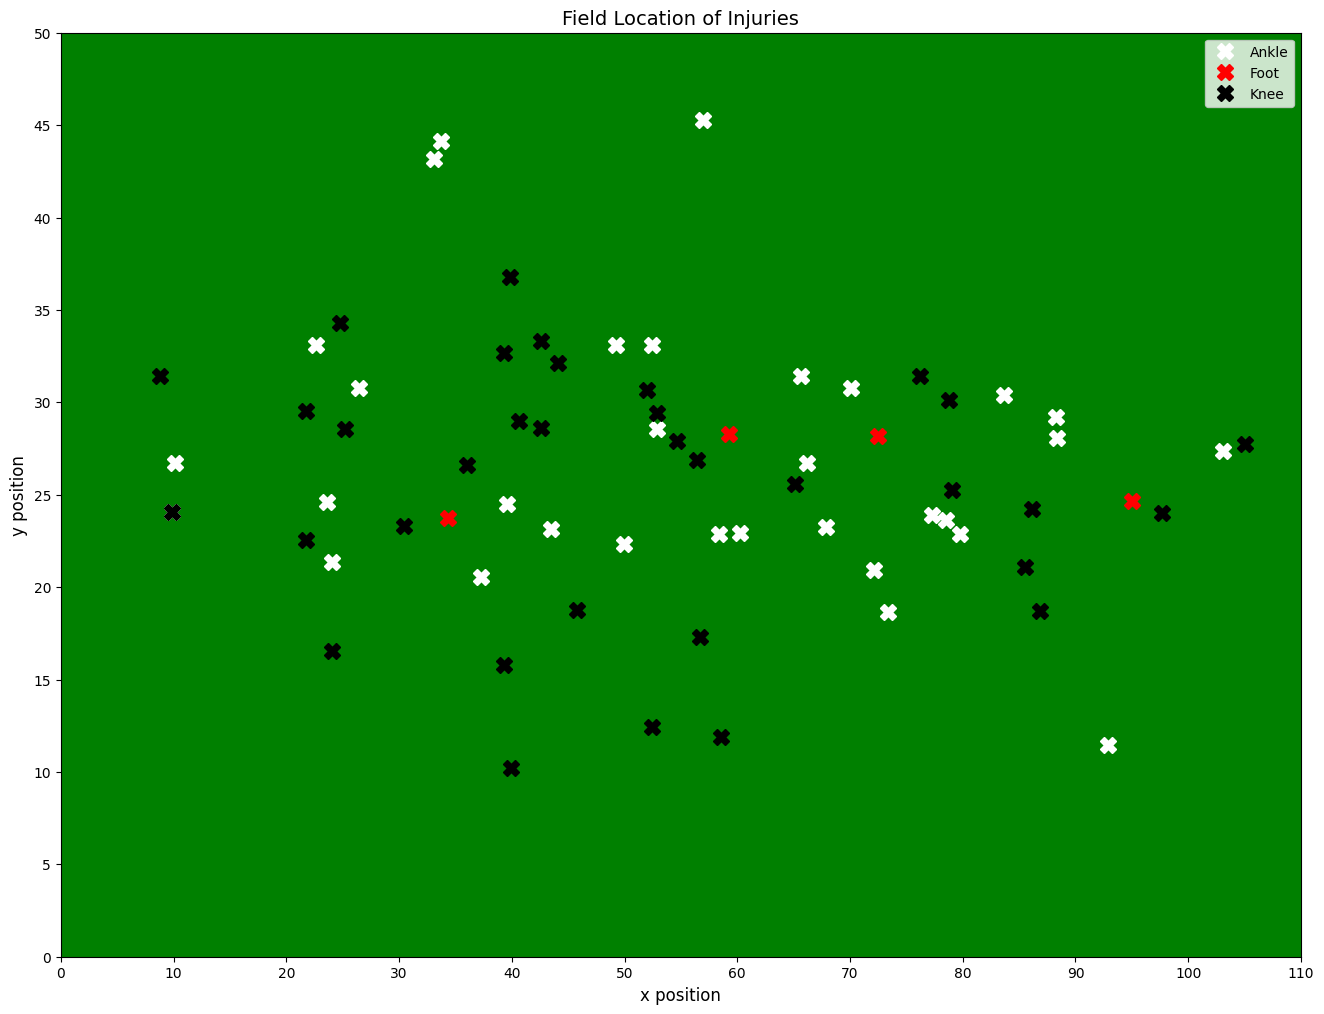

In [70]:
x = df_injury_all['x']

y = df_injury_all['y']

plt.figure(figsize = (16,12))

ax = plt.axes()
ax.set_facecolor('green')

groups = df_injury_all.groupby('BodyPart')
cols = ['white', 'red', 'black'] # color code by body part injured
for i, name in enumerate(groups):
    plt.plot(name[1].x, name[1].y, marker='X', linestyle = '', markersize=12, label=name[0], color = cols[i])

# set axes - make x and y axis size of football field (120 yards long, 55ish yards wide)
ax.set_yticks(np.arange(0, 55, 5)) 
ax.set_xticks(np.arange(0, 120, 10)) 
ax.set_xlabel('x position', size = 12)
ax.set_ylabel('y position', size = 12)
ax.set_title('Field Location of Injuries', size = 14)

plt.legend()

# nice! Now we can see which body parts were injured where - but could we look at it using a different variable?

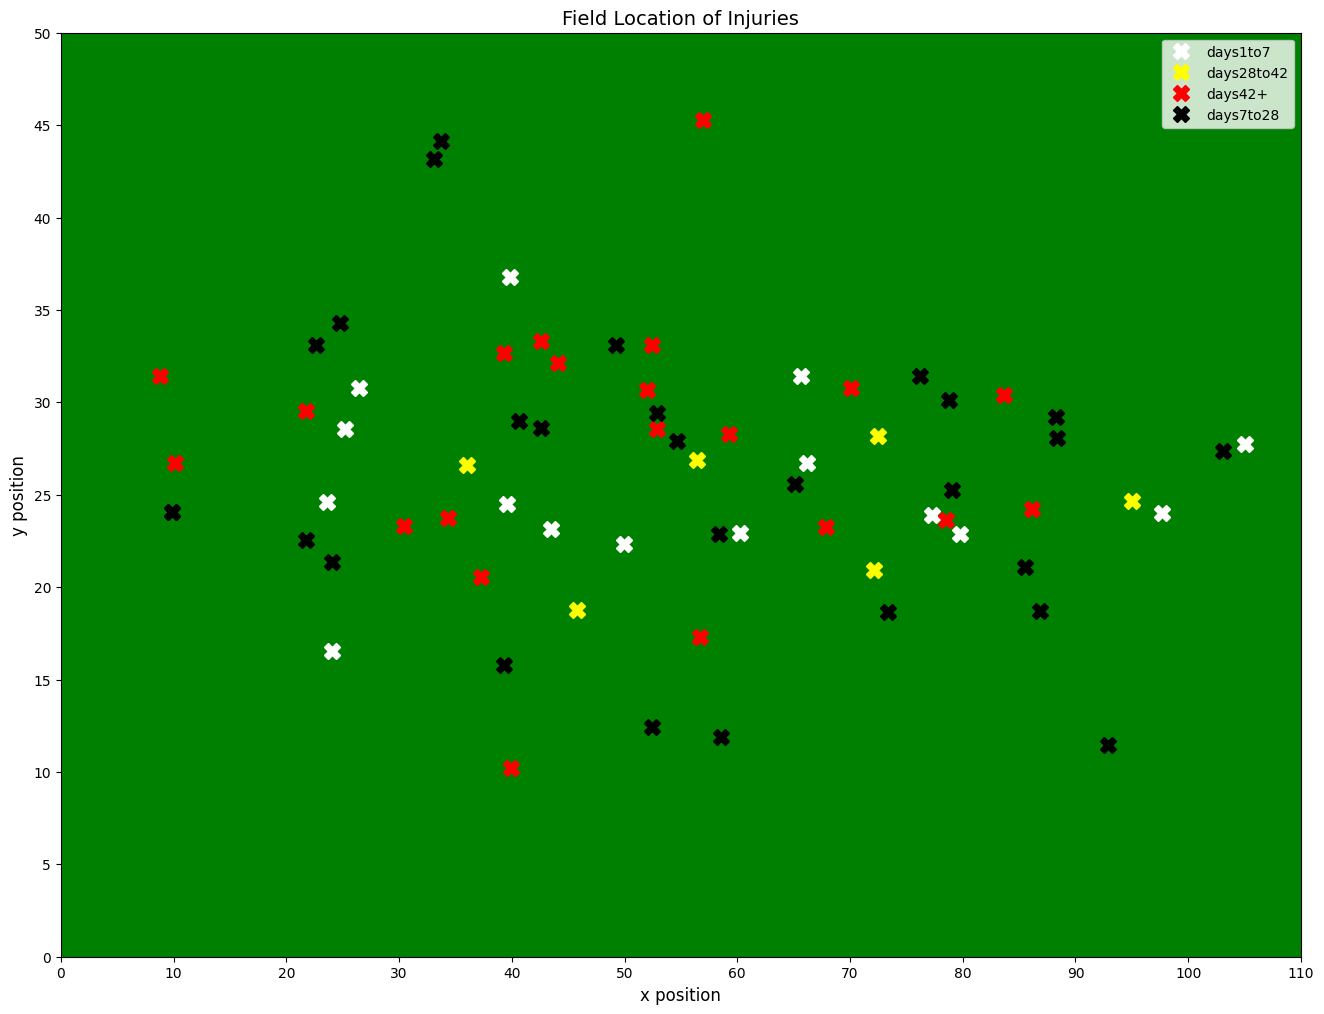

In [71]:
x = df_injury_all['x']

y = df_injury_all['y']

plt.figure(figsize = (16,12))

ax = plt.axes()
ax.set_facecolor('green')

groups = df_injury_all.groupby('time_missed')
cols = ['white', 'yellow', 'red', 'black'] # color code by body part injured
for i, name in enumerate(groups):
    plt.plot(name[1].x, name[1].y, marker='X', linestyle = '', markersize=12, label=name[0], color = cols[i])

# set axes - make x and y axis size of football field (120 yards long, 55ish yards wide)
ax.set_yticks(np.arange(0, 55, 5)) 
ax.set_xticks(np.arange(0, 120, 10)) 
ax.set_xlabel('x position', size = 12)
ax.set_ylabel('y position', size = 12)
ax.set_title('Field Location of Injuries', size = 14)

plt.legend()